# ERA-int: netCDF exploration

[List of Variables](#varlist)

[Plot](#plot)

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid
import pymongo
from pprint import pprint
from datetime import datetime, timedelta, date

In [2]:
# Open any era_int file
nc_file = '/home/dmasson/data/era-interim/era-int_multivarm1_1979-01-01_to_2017-08-31.nc'
fh = Dataset(nc_file, mode='r')

## List of Variables <a id='varlist'></a>

In [3]:
print(fh.variables)

OrderedDict([('longitude', <class 'netCDF4._netCDF4.Variable'>
float32 longitude(longitude)
    units: degrees_east
    long_name: longitude
unlimited dimensions: 
current shape = (480,)
filling off
), ('latitude', <class 'netCDF4._netCDF4.Variable'>
float32 latitude(latitude)
    units: degrees_north
    long_name: latitude
unlimited dimensions: 
current shape = (241,)
filling off
), ('time', <class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    units: hours since 1900-01-01 00:00:0.0
    long_name: time
    calendar: gregorian
unlimited dimensions: time
current shape = (464,)
filling off
), ('ci', <class 'netCDF4._netCDF4.Variable'>
int16 ci(time, latitude, longitude)
    scale_factor: 1.52594875864e-05
    add_offset: 0.499992370256
    _FillValue: -32767
    missing_value: -32767
    units: (0 - 1)
    long_name: Sea-ice cover
unlimited dimensions: time
current shape = (464, 241, 480)
filling off
), ('sst', <class 'netCDF4._netCDF4.Variable'>
int16 sst(time, latitude, longitude)

In [4]:
lons = fh.variables['longitude'][:]
lats = fh.variables['latitude'][:]
t2m = fh.variables['t2m'][:]
fh.close()

In [9]:
# Shift the grid so lons go from -180 to 180 instead of 0 to 360.
t2m_shift, lons_shift = shiftgrid(lon0=180., datain=t2m, lonsin=lons, start=False)
t2m_shift_cyclic, lons_cyclic = addcyclic(np.squeeze(t2m_shift), lons_shift)

lon, lat = np.meshgrid(lons_cyclic, lats)
this_field = t2m_shift_cyclic[11, :, :]

In [17]:
print(t2m_shift.shape)
print(type(t2m_shift))
print(type(this_field))


(464, 241, 480)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Get parameters for the stereographic projection

In [11]:
m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90,\
            llcrnrlon=-180, urcrnrlon=180, resolution='c', lon_0=0)

In [12]:
xi, yi = m(lon, lat)

In [13]:
yi

array([[ 90.  ,  90.  ,  90.  , ...,  90.  ,  90.  ,  90.  ],
       [ 89.25,  89.25,  89.25, ...,  89.25,  89.25,  89.25],
       [ 88.5 ,  88.5 ,  88.5 , ...,  88.5 ,  88.5 ,  88.5 ],
       ..., 
       [-88.5 , -88.5 , -88.5 , ..., -88.5 , -88.5 , -88.5 ],
       [-89.25, -89.25, -89.25, ..., -89.25, -89.25, -89.25],
       [-90.  , -90.  , -90.  , ..., -90.  , -90.  , -90.  ]], dtype=float32)

## Plot Data <a id='plot'></a>

/home/dmasson/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3342: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/dmasson/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3381: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


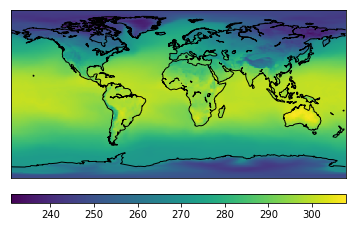

In [14]:
cs = m.pcolor(xi, yi, np.squeeze(this_field))
m.drawcoastlines()
cbar = m.colorbar(cs, location='bottom', pad="10%", cmap=plt.cm.RdBu_r)
plt.show()